## Dueling Agents in Games

We consider now the framework of Game Theory, which studies the strategic interactions between players.
Instead of our usual environments, we will use _normal-form games_ between (in our particular case) two players.

The game is defined by the action set of the two players:  $\mathcal{A}_1$ and $\mathcal{A}_2$, and by the payoff function $\mathbf{u}$, which associates the joint actions of the two players to the payoffs (rewards) of each players.
Players select their actions simultaneously, without knowing the selection of the other player, and the rewards are calculated.

When the number of actions and players is small it is convenient to write payoff functions as _matrices_.

$$
\begin{aligned}
& \text {2P, 2A payoff matrix }\\
&\begin{array}{cccc}
\hline \hline  &  &  \text{Player 2} \\
\hline  &  & A  & B \\
\text{Player 1} & A & (R_{AA}^1, R_{AA}^2) & (R_{AB}^1, R_{AB}^2) \\
 & B & (R_{BA}^1, R_{BA}^2) & (R_{BB}^1, R_{BB}^2) \\
\hline
\end{array}
\end{aligned}
$$

So, if player $1$ plays action $A$, and player $2$ plays action $B$, they receive $R_{AB}^1$ and $R_{AB}^2$ respectively.
Depending on the matrices, the game can be, for example:

- "simmetric" (if $R_{XY}^1 = R_{YX}^2$ for any action tuple $X,Y$)
- zero-sum (if $R_{XY}^1 + R_{XY}^2 = 0$ for any action tuple $X,Y$)
- ...

As in the case of simple bandits, there is no "dynamics": actions do not change the state of the game (i.e. the payoff matrix).
However, even if there is no real dynamic, the system - as perceived by one player - is changing all the time! Why?

### "Strategy"

The strategy of any player (agent, in RL terms) is defined by the probability to select the different actions (policy, in RL terms). In the dueling setup for MultiAgents, two players play game after game one versus the other, and change their strategy in response to the actions selected by the other player.

### Rock-Paper-Scissors (RPS)

There is no real need to create an entire class: the game is defined only by the payoff matrix!
Let's create the payoff matrix of the rock-paper-scissors game.

Reminder: it is a child game which is 
- zero-sum (at all times either one player wins (r=+1) and the other loses (r=-1), or both draw (r=0). 
- Rock beats Scissors (1 v -1), Scissors beats Paper (1 v -1), Paper beats Rock (1 v -1). If two players choose the same, it is a tie (0 v 0).

In [1]:
# Create a payoff matrix for the game of Rock Paper Scissors!
import matplotlib.pyplot as plt
import numpy as np

Payoff = np.zeros((2,3,3))
#actions are R P S

Payoff[0,:,:] = np.array([[0,-1,1],
                         [1,0,-1],
                         [-1,1,0]])

Payoff[1,:,:] = - Payoff[0,:,:]

print(Payoff)

[[[ 0. -1.  1.]
  [ 1.  0. -1.]
  [-1.  1.  0.]]

 [[-0.  1. -1.]
  [-1. -0.  1.]
  [ 1. -1. -0.]]]


#### Visualize a policy for RPS

What is "a strategy" in this game? How can we visualize it?
We have prob(Rock), prob(Paper) and prob(Scissors). However, only two are independent, since clearly one can be written in terms of the other two prob(Scissors) = 1 - prob(Rock) - prob(Paper).

In $3D$ therefore we can plot all possible strategies as a "triangle", where each point correspond to a specific strategy and the corners are the "pure" strategy (i.e. 100% of doing one action).

(The space in $\mathcal{R}^d$ which correspond to all possible probabilities is called a simplex $\Delta^d$).


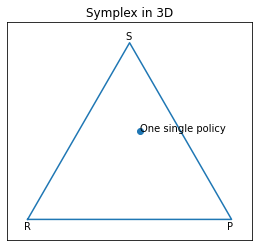

In [2]:
# How to plot policies?

plt.title('Symplex in 3D')

plt.xlim(-0.6,0.6)
plt.ylim(-0.1,np.sqrt(3)/2+0.1)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    left=False,
    right=False,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False, # labels along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.text(-0.02, np.sqrt(3)/2+0.02,'S')
plt.text(-0.52, -0.05,'R')
plt.text(0.48, -0.05,'P')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([-0.5, 0.5, 0, -0.5], [0,0,np.sqrt(3)/2,0])

# What about a single policy?
#    P(R), P(P), P(S)
pi = [0.2,  0.3, 0.5]

# This policy maps to a (x,y), such that:
# x = (P(P) - P(R)) / 2
# y = P(S)
pi_projected = ((pi[1] - pi[0])/2 , pi[2] * np.sqrt(3)/2)

plt.text(*pi_projected, 'One single policy')

plt.scatter(*pi_projected)

In [3]:
# Utility to plot trajectories
def plot_traj(trajs, labels):

    proj_trajs = []
    for traj in trajs:
        x_proj, y_proj = project_pi(traj)
        proj_trajs.append([x_proj, y_proj])
        
    plt.title('Trajectory of policies')

    ylim = -0.1
    if labels:
        ylim -= 0.1*len(labels)
    
    plt.xlim(-0.6,0.6)
    plt.ylim(ylim,np.sqrt(3)/2+0.1)

    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        left=False,
        right=False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False, # labels along the bottom edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.text(-0.02, np.sqrt(3)/2+0.02,'S')
    plt.text(-0.52, -0.05,'R')
    plt.text(0.48, -0.05,'P')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([-0.5, 0.5, 0, -0.5], [0,0,np.sqrt(3)/2,0])

    if labels:
        for proj_traj, label in zip(proj_trajs, labels):
            plt.plot(proj_traj[0], proj_traj[1], label=label)
            plt.scatter(proj_traj[0][-1], proj_traj[1][-1])
        plt.legend(loc='lower left')
    else:
        for proj_traj in proj_trajs:
            plt.plot(proj_traj[0], proj_traj[1])
            plt.scatter(proj_traj[0][-1], proj_traj[1][-1])
        

In [4]:
# Here we go from a trajectory for RockPaperScissor policies to its projection for plot.
def project_pi(traj_pi):
    pi_x_projected = (traj_pi[:,1] - traj_pi[:,0])/2
    pi_y_projected = traj_pi[:,2]*np.sqrt(3)/2
    return pi_x_projected, pi_y_projected

### Create an agent (standard gradient)

The individual player is a RL agent, which acts in a (changing) environment, which depends on the actions of the 

Therefore, we will use a RL algorithm among those we have already written. Which one?

Q: Can we use model-based algorithm? (Do we know exactly the model?)

#### What are the characteristics of the agent?

- Number of states?
- Policy?
- Episode length?
- Is there a future discount?

In [5]:
class AgentForDuel():
    def __init__(self, 
                 action_size,
                 lr=0.01):
        
        self.action_size = action_size
        self.lr = lr
        self.Theta = np.random.rand( self.action_size)
        
    def single_update(self, a, r):
        
        policy = self.get_policy()
        
        for act in range(self.action_size):
            # If the action "act" is that which was really chosen in the trajectory
            if (act == a):
                self.Theta[ act ] += self.lr * r * (1 - policy[act])
            # Else if the action "act" has not been performed
            else:
                self.Theta[ act ] += self.lr * r * (- policy[act])
            
    def get_policy(self):
        """
        Returns policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 
        
        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta - np.max(self.Theta)
        
        #print('max', np.max(self.Theta))
                
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
            
        return prob_actions
    
    def get_action(self):
        """
        Chooses action at random using policy from current parameters Theta.
        """
        
        policy = self.get_policy()
        a = np.random.choice(self.action_size, p=policy)
        
        return a

### The dueling setup.

Now, let's put one agent against another, and let's make learn simultaneously.


In [6]:
Payoff = np.zeros((2,3,3))
#actions are R P S

Payoff[0,:,:] = np.array([[0,-1,1],
                         [1,0,-1],
                         [-1,1,0]])

# Exploit the zero-sum 
Payoff[1,:,:] = - Payoff[0,:,:]

N_plays = 100000

P1 = AgentForDuel(3, lr=0.001)
P2 = AgentForDuel(3, lr=0.001)

P1.Theta = np.array([-2.,0.,-2.])
P2.Theta = np.array([0.,-2.,-2.])

traj_policy_P1 = []
traj_policy_P2 = []

momo = np.zeros((2,3))

for i in range (N_plays):
    
    a1 = P1.get_action() # Select random action from Player1
    a2 = P2.get_action() # Select random action from Player2
    
    
    r1 = Payoff[0,a1,a2] # Select payoff for P1 given a1, a2
    r2 = Payoff[1,a1,a2] # Select payoff for P2 given a1, a2
    
    # Update policy for P1
    P1.single_update(a1,r1)
    # Update policy for P2
    P2.single_update(a2,r2)
    
    # Record policy of P1
    traj_policy_P1.append(P1.get_policy())
    # Record policy of P2
    traj_policy_P2.append(P2.get_policy())

traj_policy_P1 = np.vstack(traj_policy_P1)
traj_policy_P2 = np.vstack(traj_policy_P2)

Let's plot the trajectory in policy space!

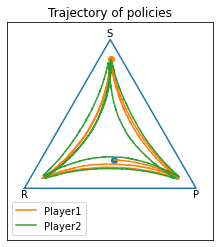

In [7]:
plot_traj([traj_policy_P1, traj_policy_P2], ['Player1', 'Player2'])

### Create an agent (normal gradient)

#### (Optional: Intuitive theory of normal gradient. Otherwise, just go to practice
Now, let's use the concept of *normal* gradient. Where does it come from?

Let's recall the main idea of gradient based minimization.
In general, we have a function $f(x)$ we want to minimize, we are at some point $x_t$ and we have an estimate of the gradient there $ \partial_x f(x_t)$. Then, we can construct an approximation of the function:

$$
f_{approx}(x) = f(x_t) + \partial_x f(x_t) (x-x_t)
$$

Clearly, if we minimize that, we would move infinitely in the direction of the gradient. This is wrong, because generally, the linear approximation is valid only _close_ to $x_t$. Therefore, we minimize a different term:

$$
\mathcal{L}(x) = f(x_t) + \partial_x f(x_t) (x-x_t) + \frac{1}{2\alpha} ( x - x_t)^2
$$

The term $\frac{1}{2\alpha} ( x - x_t)^2$ tells us "not to go too far" away from $x_t$!

Putting $\partial_x \mathcal{L}(x) = 0$, we get the typical update rule:

$$
x = x_t - \alpha \partial_x f(x_t)
$$


#### How do we apply that to PG?

Now, we don't have a $f(x)$, however we have an expected return $\mathcal{J}$ which is a function of the policy $\pi$ _through_ the parameters $\theta$. The standard update, would then correspond to the minimization of:


$$
\mathcal{L}(\pi | \theta) = \mathcal{J}(\pi | \theta_t) + \nabla_\theta \mathcal{J}(\pi | \theta_t) (\theta - \theta_t) + \frac{1}{2\alpha} || \theta-\theta_t|| ^2
$$

*However*, we now can see that there is an interesting thing. The equation above tells us, "change $\theta$ in the direction of the gradient, but don't change $\theta$ too much, else the gradient will be wrong!". 

However, the function of interest $\mathcal{J}$ and its gradient does not depend on $\theta$ directly, but on the _policies!_. It may well be that $\theta$ change A LOT, while the gradient remains the same! 

So, it should really say: "change $\theta$ in the direction of the gradient, but don't change *the policy $\pi$$ too much!". So we just need some measure of "distance" between policies, which is the Kullback-Leibler divergence.

$$
|| \theta-\theta_t||^2 \longrightarrow D_{KL}(\, \pi_\theta \, || \, \pi_{\theta_t} \, )
$$

So we want to "move as quickly as possible in the direction of $\theta$ where policies do not change" and be "move cautiously" in directions where policies change fast.
It turns out that we can achieve this if instead of the gradient $\nabla$ we follow the **natural gradient** $\tilde{\nabla} = F[\theta]^{-1} \cdot \nabla$, where $F[\theta]$ is the Fisher Matrix, defined as:

$$
F[\theta]_{i,j} = \sum_a \pi(a) \frac{\partial \text{log} \pi(a)}{\partial \theta_i} \frac{\partial \text{log}\pi(a)}{\partial \theta_j}
$$

### Yes, ok... But how, in practice?

Let us consider the parametrization of the policies used so far, with $N$ parameters $(\theta_1, \theta_2, \dots, \theta_N)$ for $N$ actions. (Ignoring for simplicity the dependence on the state). 


$$
\begin{eqnarray}
\pi(a | \theta) &=& \pi(a) &= \frac{e^{\theta_a}}{\sum_j e^{\theta_j}} \\
\end{eqnarray}
$$

Let us recall that
$$
    \nabla_i \text{log}\pi(a) = \frac{\partial \text{log } \pi(a)}{\partial \theta_i} = \left\{
    \begin{array}{clll}
        & 1-\pi(i)  \,\,\,& \text{if} \,\, a = i \\[2ex]
        & - \pi(i) \,\,\,& \text{if} \,\, a \neq i \\[2ex]
\end{array}
    \right.
$$

In a more concise way, we have that

$$
\frac{\partial \text{log } \pi(a)}{\partial \theta_i} = \mathbb{1}_{(a=i)} - \pi(i) \\
$$

Now we can construct the Fisher Information Matrix. The $(i,j)^{th}$ element of the matrix is:

$$
\begin{eqnarray}
F[\theta]_{i,j} &=& \sum_a \pi_a \frac{\partial \text{log} \pi(a)}{\partial \theta_i} \frac{\partial \text{log}\pi(a)}{\partial \theta_j} \\
&=& \sum_a \pi(a) \big(\mathbb{1}_{(a=i)} - \pi(i)\big)\big(\mathbb{1}_{(a=j)} - \pi(j)\big) \\
&=& \sum_a \pi(a) \big(\mathbb{1}_{(a=i)}\mathbb{1}_{(a=j)} - \mathbb{1}_{(a=j)}\pi(i) - \mathbb{1}_{(a=i)}\pi(j) + \pi(j)\pi(i)\big) \\
&=& \pi(i) \mathbb{1}_{(i=j)} - \pi(j)\pi(i)
\end{eqnarray}
$$

One more step is needed!
As we write the natural gradient $\tilde{\nabla} = F[\theta]^-1 \nabla$ we can equivalently express the standard gradient as $F[\theta] \tilde{\nabla} = \nabla$. 
Expressing the matrix product explicitly for a single derivative $\partial/\partial{\theta_i} $ we have:

$$
\sum_j F[\theta]_{i,j} \tilde{\nabla}_j = \nabla_i = \partial/\partial{\theta_i}
$$

Let us now apply the natural gradient to $\text{log}(\pi(a))$ (where $a$ is the action which enters in the Action-Critic update):

$$
\begin{eqnarray}
\sum_j F[\theta]_{i,j} \tilde{\nabla}_j \text{log}(\pi(a))&=& \partial/\partial{\theta_i} \text{log}(\pi(a))\\
\sum_j (\pi(i) \mathbb{1}_{(i=j)} - \pi(j)\pi(i)) \left[ \tilde{\nabla}_j \text{log}(\pi(a)) \right] &=& \mathbb{1}_{(a=i)} - \pi(i)\\
\end{eqnarray}
$$

Solving the equation above, we can finally find the explicit expression for the natural gradient in the case of the soft-max policies.

$$
\tilde{\nabla}_j \text{log}(\pi(a)) = \frac{\mathbb{1}_{(a=j)}}{\pi(j)} 
$$

Notice what happens when $\pi \rightarrow 0$. The standard gradient goes also to $0$, and therefore the value $\theta$ is "stuck" there. However for the natural gradient if $\pi \rightarrow 0$ the corresponding update on $\theta$ can be potentially unbounded!

# End of the theory!

### Create an agent with Natural Gradient!

Does everything seem too overwhelming? No worries!
The modifications are actually super simple to make!

The only thing to change is the update. Instead of the "standard gradient", 

$$
\frac{\partial \text{log } \pi(a)}{\partial \theta_b} = \mathbb{1}_{(a=b)} - \pi(b) \\
$$

We will have to code the "natural gradient" for softmax, which is:

$$
\frac{\tilde{\partial} \text{log } \pi(a)}{\partial \theta_b} = \frac{\mathbb{1}_{(a=b)}}{\pi(b)} 
$$



In [8]:
class AgentForDuel_NaturalGradient():
    def __init__(self, 
                 action_size,
                 lr=0.01):
        
        self.action_size = action_size
        self.lr = lr
        self.Theta = np.random.rand( self.action_size)
        
    def single_update(self, a, r):
        
        policy = self.get_policy()
        
        self.Theta[ a ] += self.lr * r / policy[a]
        
        
    def get_policy(self):
        """
        Returns policy from current parameters Theta.
        """
        # Prob(a|s) = exp(theta_a) / (sum_a' exp(theta_a') 
        
        # Common shift has no influence on relative probabilities
        # But very helpful: Otherwise it can explode! 
        log_prob = self.Theta - np.max(self.Theta)
                
        prob_actions = np.exp(log_prob)
        prob_actions = prob_actions / np.sum(prob_actions)
            
        return prob_actions
    
    def get_action(self):
        """
        Chooses action at random using policy from current parameters Theta.
        """
        
        policy = self.get_policy()
        a = np.random.choice(self.action_size, p=policy)
        
        return a

Now, let's do the dueling as before, but using the natural gradient.


In [9]:
Payoff = np.zeros((2,3,3))
#actions are R P S

Payoff[0,:,:] = np.array([[0,-1,1],
                         [1,0,-1],
                         [-1,1,0]])

# Exploit the zero-sum 
Payoff[1,:,:] = - Payoff[0,:,:]

N_plays = 300000

P1 = AgentForDuel_NaturalGradient(3, lr=0.00025)
P2 = AgentForDuel_NaturalGradient(3, lr=0.00025)

P1.Theta = np.array([-1.,0,0])
P2.Theta = np.array([0.,-2.,0])

traj_policy_P1_NG = []
traj_policy_P2_NG = []

for i in range (N_plays):
    
    a1 = P1.get_action() # Select random action from Player1
    a2 = P2.get_action() # Select random action from Player2
    
    r1 = Payoff[0,a1,a2] # Select payoff for P1 given a1, a2
    r2 = Payoff[1,a1,a2] # Select payoff for P2 given a1, a2

    # Update policy for P1
    P1.single_update(a1,r1)
    # Update policy for P2
    P2.single_update(a2,r2)
    
    # Record policy of P1
    traj_policy_P1_NG.append(P1.get_policy())
    # Record policy of P2
    traj_policy_P2_NG.append(P2.get_policy())

traj_policy_P1_NG = np.vstack(traj_policy_P1_NG)
traj_policy_P2_NG = np.vstack(traj_policy_P2_NG)

### And now let's plot the trajectories in the policy space.

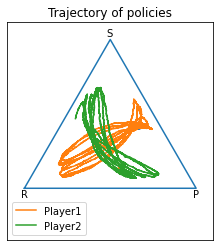

In [11]:
plot_traj([traj_policy_P1_NG, traj_policy_P2_NG], ['Player1', 'Player2'])


### Replicator Dynamics

As you have seen in the theory, the evolution of the Natural Gradient agent which learns by self-play is equivalent to that of the Replicator Dynamics:

$$
\dot{\pi}(a) = \pi(a)[\sum_b u(a,b)\pi(b) - \sum_{a'}\sum_b u(a',b) \pi(a')\pi(b)]
$$
Or in shorthand:
$$
\dot{\pi}(a) = \pi(a)[u(a) - \bar{u}] 
$$

What does this mean? The policy $\pi(a)$ of the RL can be seen as the fraction of the total population which follows the "pure" strategy $a$ (i.e. it will always choose action $a$). The Replicator Dynamics models how the different fraction will grow in time.


In [12]:
Payoff = np.zeros((2,3,3))
#actions are R P S

Payoff[0,:,:] = np.array([[0,-1,1],
                         [1,0,-1],
                         [-1,1,0]])

# Exploit the zero-sum 
Payoff[1,:,:] = - Payoff[0,:,:]

N_plays = 20000

PI = np.array([0.1, 0.1, 0.8])
PI /= np.sum(PI)

lr_PI = 0.001

traj_policy_RD = []

for i in range (N_plays):

         #      P, a, b
    u_a = np.einsum('ab, b -> a', Payoff[0, :, :], PI) # expected utility for actions
    u_bar = np.dot(u_a, PI) # average expected utility

    # Update PI following replicator dynamics
    PI += lr_PI * PI * (u_a - u_bar)
    # Record policy of P1
    traj_policy_RD.append(PI.copy())

traj_policy_RD = np.vstack(traj_policy_RD)

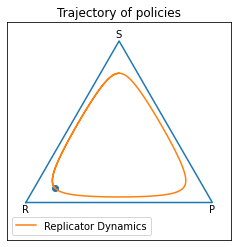

In [13]:
plot_traj([traj_policy_RD], ['Replicator Dynamics'])

## Compare with Normal Gradient

In [ ]:
Payoff = np.zeros((2,3,3))
#actions are R P S

Payoff[0,:,:] = np.array([[0,-1,1],
                         [1,0,-1],
                         [-1,1,0]])

# Exploit the zero-sum 
Payoff[1,:,:] = - Payoff[0,:,:]

N_plays = 300000

P1 = AgentForDuel_NaturalGradient(3, lr=0.000025)

P1.Theta = np.array([np.log(0.1), np.log(0.1) , np.log(0.8)])

traj_policy_P1_NG = []

for i in range (N_plays):
    
    a1 = P1.get_action() # Select random action from Player1
    a2 = P1.get_action() # Select random action from Player2
    
    r1 = Payoff[0,a1,a2] # Select payoff for P1 given a1, a2
    r2 = Payoff[1,a1,a2] # Select payoff for P2 given a1, a2

    # Update policy for P1
    P1.single_update(a1,r1)
    P1.single_update(a2,r2)
    
    # Record policy of P1
    traj_policy_P1_NG.append(P1.get_policy())

traj_policy_P1_NG = np.vstack(traj_policy_P1_NG)


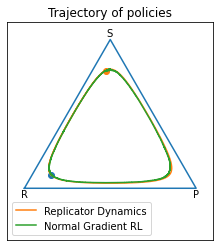

In [110]:
plot_traj([traj_policy_RD, traj_policy_P1_NG], ['Replicator Dynamics', 'Normal Gradient RL'])

## Compare with Standard Gradient

In [111]:
Payoff = np.zeros((2,3,3))
#actions are R P S

Payoff[0,:,:] = np.array([[0,-1,1],
                         [1,0,-1],
                         [-1,1,0]])

# Exploit the zero-sum 
Payoff[1,:,:] = - Payoff[0,:,:]

N_plays = 300000

P1 = AgentForDuel(3, lr=0.0001)

P1.Theta = np.array([np.log(0.1), np.log(0.1) , np.log(0.8)])

traj_policy_P1 = []

for i in range (N_plays):
    
    a1 = P1.get_action() # Select random action from Player1
    a2 = P1.get_action() # Select random action from Player2
    
    r1 = Payoff[0,a1,a2] # Select payoff for P1 given a1, a2
    r2 = Payoff[1,a1,a2] # Select payoff for P2 given a1, a2

    # Update policy for P1
    P1.single_update(a1,r1)
    P1.single_update(a2,r2)
    
    # Record policy of P1
    traj_policy_P1.append(P1.get_policy())

traj_policy_P1 = np.vstack(traj_policy_P1)


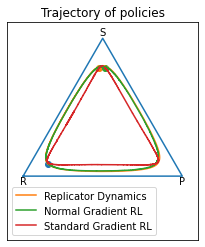

In [112]:
plot_traj([traj_policy_RD, traj_policy_P1_NG, traj_policy_P1], ['Replicator Dynamics', 'Normal Gradient RL', 'Standard Gradient RL'])